In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor


***Data Dividing***

In [4]:
import glob

chasedb1_path = '/media/mountHDD2/chasedb1'

image_files = glob.glob(chasedb1_path + '/*.jpg')
mask_files = glob.glob(chasedb1_path + '/*1stHO.png')

image_files.sort()
mask_files.sort()

img_dir = []
mask_dir = []

# Tạo danh sách các cặp (image, mask)
image_mask_pairs = [(image, mask) for image, mask in zip(image_files, mask_files)]

for pair in image_mask_pairs:
    img_dir.append(pair[0])  
    mask_dir.append(pair[1]) 

In [7]:
print(len(img_dir),len(mask_dir))

28 28


***Custorm Dataset***


In [8]:
class ChasedbT(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.imgs = img_dir  
        self.msks = mask_dir 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #The mean and std of ImageNet,Medical images must be counted separately 
    ]
)
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = ChasedbT( img_dir=img_dir, mask_dir=mask_dir,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

28


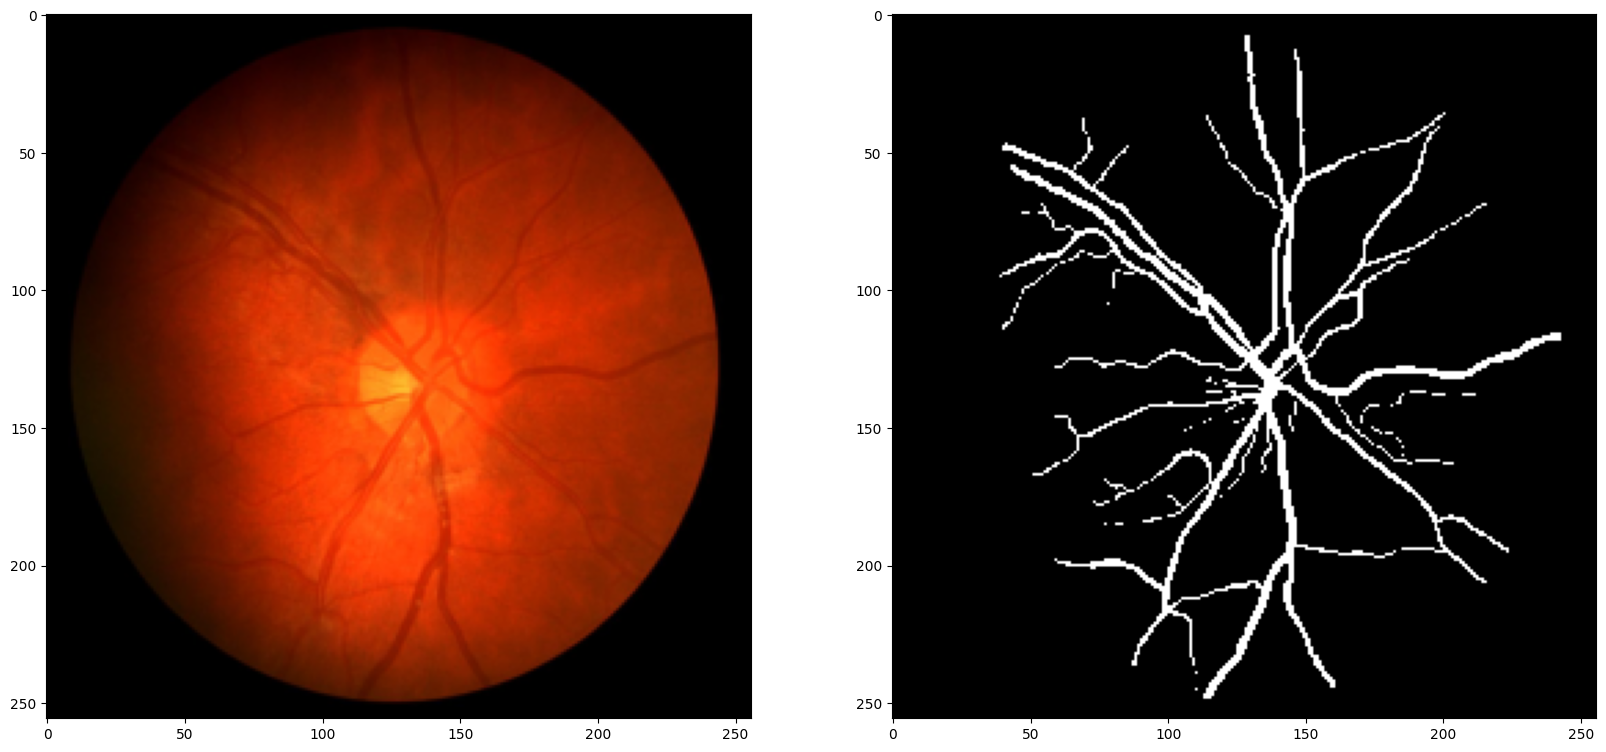

In [10]:

img, msk = Data_transfered[27]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [11]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 23
Testing Samples: 5


In [12]:
sample_data, sample_mask = train_ds[10]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0. 1.]


***Training***

In [14]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out

In [15]:
class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

In [16]:
class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [17]:
class R2U_Net(nn.Module):
    """https://arxiv.org/abs/1802.06955"""
    def __init__(self, img_ch=3, output_ch=3, t=2, ini_filter = 16):
        super(R2U_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool1(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool2(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool3(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)      

        return out

In [18]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
#device = torch.device("cpu")
model = R2U_Net(3,1,2,16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [23]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.09it/s]


Epoch: 0 - TrainLoss: 0.014217828197971634


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.67it/s]


Epoch: 1 - TrainLoss: 0.013452158309519291


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.35it/s]


Epoch: 2 - TrainLoss: 0.014625080051305502


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.22it/s]


Epoch: 3 - TrainLoss: 0.014397368361444576


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.05it/s]


Epoch: 4 - TrainLoss: 0.014696855705393396


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.21it/s]


Epoch: 5 - TrainLoss: 0.015130925964078178


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.64it/s]


Epoch: 6 - TrainLoss: 0.016501265213541363


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.00it/s]


Epoch: 7 - TrainLoss: 0.018113480030518513


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.65it/s]


Epoch: 8 - TrainLoss: 0.02056425943484773


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.57it/s]


Epoch: 9 - TrainLoss: 0.019647201847123062


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.60it/s]


Epoch: 10 - TrainLoss: 0.016827933692737766


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.09it/s]


Epoch: 11 - TrainLoss: 0.01481215230634679


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.61it/s]


Epoch: 12 - TrainLoss: 0.013054179999491444


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.92it/s]


Epoch: 13 - TrainLoss: 0.01284823959450359


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.90it/s]


Epoch: 14 - TrainLoss: 0.012512790768042854


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.14it/s]


Epoch: 15 - TrainLoss: 0.013043259958858076


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.11it/s]


Epoch: 16 - TrainLoss: 0.013348152699029964


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.40it/s]


Epoch: 17 - TrainLoss: 0.014190739223166653


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.49it/s]


Epoch: 18 - TrainLoss: 0.012436588578250097


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.30it/s]


Epoch: 19 - TrainLoss: 0.01224979555801205


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.34it/s]


Epoch: 20 - TrainLoss: 0.011137961855401163


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.87it/s]


Epoch: 21 - TrainLoss: 0.010448846723074499


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.01it/s]


Epoch: 22 - TrainLoss: 0.01024400070309639


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.06it/s]


Epoch: 23 - TrainLoss: 0.010738684876781443


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.50it/s]


Epoch: 24 - TrainLoss: 0.010840169235092142


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.32it/s]


Epoch: 25 - TrainLoss: 0.010849274128027584


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.53it/s]


Epoch: 26 - TrainLoss: 0.01056170969715585


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.24it/s]


Epoch: 27 - TrainLoss: 0.010229680079804815


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.93it/s]


Epoch: 28 - TrainLoss: 0.010990288088341122


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.35it/s]


Epoch: 29 - TrainLoss: 0.011506428456176882


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.39it/s]


Epoch: 30 - TrainLoss: 0.013384567047266857


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.53it/s]


Epoch: 31 - TrainLoss: 0.01434262647576954


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.13it/s]


Epoch: 32 - TrainLoss: 0.017327437055823597


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.69it/s]


Epoch: 33 - TrainLoss: 0.02046396360611138


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.60it/s]


Epoch: 34 - TrainLoss: 0.021141217778558315


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.69it/s]


Epoch: 35 - TrainLoss: 0.014750072449121786


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.82it/s]


Epoch: 36 - TrainLoss: 0.010609566396021324


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.65it/s]


Epoch: 37 - TrainLoss: 0.00822002659349338


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.31it/s]


Epoch: 38 - TrainLoss: 0.00660317617913951


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.21it/s]


Epoch: 39 - TrainLoss: 0.00579800547869957


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.90it/s]


Epoch: 40 - TrainLoss: 0.0054634403153930025


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.40it/s]


Epoch: 41 - TrainLoss: 0.005167720616673646


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.09it/s]


Epoch: 42 - TrainLoss: 0.004877740598243216


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.11it/s]


Epoch: 43 - TrainLoss: 0.005061134372068488


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.90it/s]


Epoch: 44 - TrainLoss: 0.004795904230812322


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.59it/s]


Epoch: 45 - TrainLoss: 0.004789120163363607


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.98it/s]


Epoch: 46 - TrainLoss: 0.005408270841302431


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.90it/s]


Epoch: 47 - TrainLoss: 0.0059110855116792345


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.08it/s]


Epoch: 48 - TrainLoss: 0.006717815813001083


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.86it/s]


Epoch: 49 - TrainLoss: 0.007439258710845657


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.45it/s]


Epoch: 50 - TrainLoss: 0.008768322776355173


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.95it/s]


Epoch: 51 - TrainLoss: 0.011343539226800203


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.26it/s]


Epoch: 52 - TrainLoss: 0.012950222655806852


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.72it/s]


Epoch: 53 - TrainLoss: 0.013887893206075481


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.00it/s]


Epoch: 54 - TrainLoss: 0.013069488675050114


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.21it/s]


Epoch: 55 - TrainLoss: 0.01029440173474343


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.00it/s]


Epoch: 56 - TrainLoss: 0.009059309635473333


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.27it/s]


Epoch: 57 - TrainLoss: 0.007269529119619857


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.30it/s]


Epoch: 58 - TrainLoss: 0.006703766852455295


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.02it/s]


Epoch: 59 - TrainLoss: 0.006565965205916892


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.18it/s]


Epoch: 60 - TrainLoss: 0.006072120396825282


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.25it/s]


Epoch: 61 - TrainLoss: 0.005522529189677342


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.35it/s]


Epoch: 62 - TrainLoss: 0.005538567708319296


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.32it/s]


Epoch: 63 - TrainLoss: 0.005279897206017505


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.00it/s]


Epoch: 64 - TrainLoss: 0.0057850969226463985


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.25it/s]


Epoch: 65 - TrainLoss: 0.006025606179204972


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.11it/s]


Epoch: 66 - TrainLoss: 0.007074814107592987


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.38it/s]


Epoch: 67 - TrainLoss: 0.009531223518854898


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.80it/s]


Epoch: 68 - TrainLoss: 0.011708773773811434


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.23it/s]


Epoch: 69 - TrainLoss: 0.013200893836176914


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.30it/s]


Epoch: 70 - TrainLoss: 0.011914552067932875


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.37it/s]


Epoch: 71 - TrainLoss: 0.010534846122660067


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.19it/s]


Epoch: 72 - TrainLoss: 0.00867166465310299


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.47it/s]


Epoch: 73 - TrainLoss: 0.007030444158970014


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.93it/s]


Epoch: 74 - TrainLoss: 0.006065089073356079


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.23it/s]


Epoch: 75 - TrainLoss: 0.004832802573218942


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.87it/s]


Epoch: 76 - TrainLoss: 0.004089188620286143


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.29it/s]


Epoch: 77 - TrainLoss: 0.003305701700889546


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.92it/s]


Epoch: 78 - TrainLoss: 0.002564374104385143


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.92it/s]


Epoch: 79 - TrainLoss: 0.001964470427280859


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.60it/s]


Epoch: 80 - TrainLoss: 0.001663103153038284


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.00it/s]


Epoch: 81 - TrainLoss: 0.0013300519887074504


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.08it/s]


Epoch: 82 - TrainLoss: 0.0010740056193595672


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.59it/s]


Epoch: 83 - TrainLoss: 0.0008747740927071351


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.28it/s]


Epoch: 84 - TrainLoss: 0.0007452891808023434


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.04it/s]


Epoch: 85 - TrainLoss: 0.0006166487342536287


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.58it/s]


Epoch: 86 - TrainLoss: 0.0004935869415614592


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.48it/s]


Epoch: 87 - TrainLoss: 0.0004060218052472919


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.63it/s]


Epoch: 88 - TrainLoss: 0.00034730746625902373


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.95it/s]


Epoch: 89 - TrainLoss: 0.00030091700192196697


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.70it/s]


Epoch: 90 - TrainLoss: 0.00026839372256527776


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.85it/s]


Epoch: 91 - TrainLoss: 0.00023521658358336225


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.77it/s]


Epoch: 92 - TrainLoss: 0.00021931834698593974


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.78it/s]


Epoch: 93 - TrainLoss: 0.0002009004481648014


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.44it/s]


Epoch: 94 - TrainLoss: 0.00018517002773359823


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.51it/s]


Epoch: 95 - TrainLoss: 0.0002043433496905693


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.03it/s]


Epoch: 96 - TrainLoss: 0.0001793183391387372


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.16it/s]


Epoch: 97 - TrainLoss: 0.00016345224740570816


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.59it/s]


Epoch: 98 - TrainLoss: 0.00015412955152619955


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.58it/s]

Epoch: 99 - TrainLoss: 0.00013970219468161383


<All keys matched successfully>

In [24]:
# Lưu parameters
torch.save(best_dct, 'parameter_runet_v1.pth')


In [ ]:
#best_model = AttU_Net()  
#best_model.load_state_dict(torch.load('parameter_runet_v1.pth'))

In [25]:
test_img_dir= '/home/chuyenmt/Chuyen_explore-Copy1/Test_Drive'

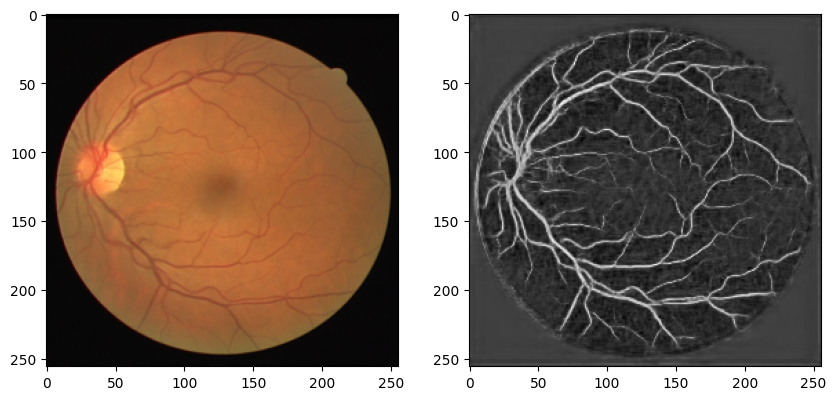

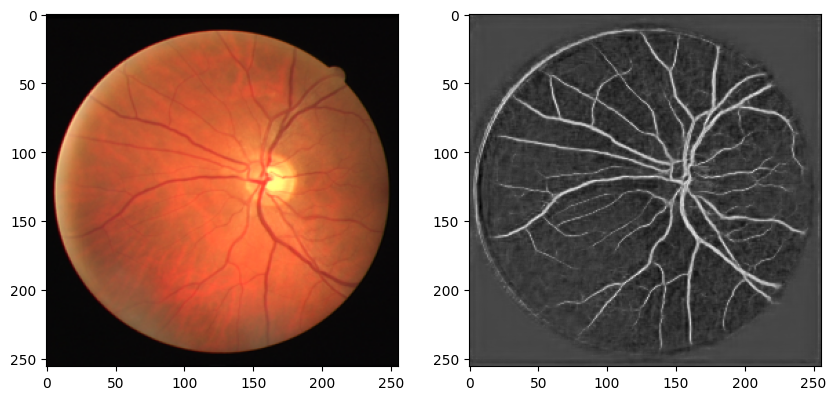

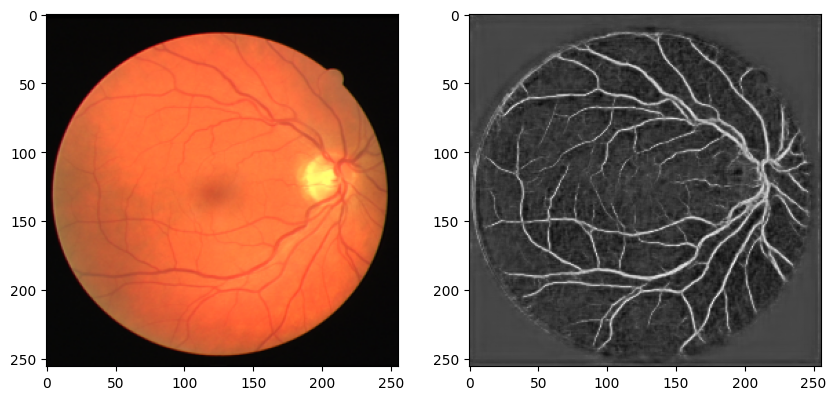

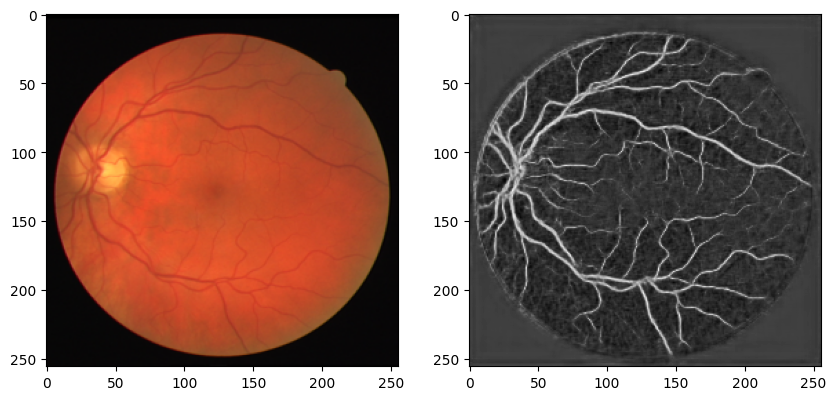

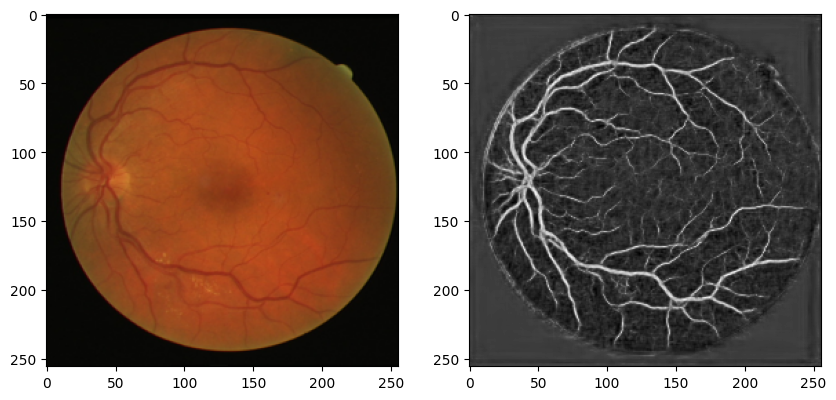

In [26]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
